In [1]:
# install pyspark
!pip3 install pyspark

In [2]:
#initialize SparkSession and installed Required Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


In [5]:
# Load the data from a CSV file
df = spark.read.csv("/property.csv", header=True, inferSchema=True)

# get familiar with data

In [6]:
# get familiar with data
df.show()

# more info
print("Total Records",df.count())
print("Total Partitions ",df.rdd.getNumPartitions())

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
|          3944|           6|            2|      1938|    3542| 845638.1354384426|
|          3671|           2|            1|      1963|    5105| 748779.2192281872|
|          3419|           4|            2|      1925|    5448| 743007.2614135538|
|           630|           2|            2|      2012|    3204| 135656.4528785377|
|   

In [7]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c))
.alias(c) for c in df.columns]).show()

+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [8]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Square_Footage","Num_Bedrooms","Num_Bathrooms","Year_Built","Lot_Size"],
                           outputCol = "Features")

In [11]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")

In [13]:
#create linear regression model.
regressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features'
                             )

In [14]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LR1saved_model")

In [15]:
pipelineModel = Pipeline.load('./pipeline_LR1saved_model')

In [16]:
data_train , data_test = df.randomSplit([0.6,0.4], seed = 123)

In [17]:
Model = pipeline.fit(data_train)

In [18]:
print("total LR cofficents",len(Model.stages[2].coefficients) )
print("Cofficientents",Model.stages[2].coefficients)
print("Intecept",Model.stages[2].intercept)

total LR cofficents 5
Cofficientents [259896.92144676342,8498.23057121344,3369.7159054208514,-3494.9343577615205,251.5068548811221]
Intecept 200721.1114282388


In [20]:
#n the prediction phase, we test our model on some unseen data.
pred = Model.transform(data_test)
pred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118903.66598607796|108508.56360442274|
|118117.98619074191|117632.63219959654|
|109859.29636851994|106670.25438504865|
|123571.35331775977|117919.45375887671|
|112841.82931978161|119893.50473253023|
|114487.60713844467|115218.14440379351|
|125777.54987879253|142918.60554292126|
|125373.82320041412|121701.09755089099|
|121766.59370884892|95443.54011673816 |
|115321.26527785618|111392.17048643339|
+------------------+------------------+
only showing top 10 rows



In [21]:
#create linear regression model.
Lasoregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [22]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118904.12924656043|108508.56360442274|
|118118.43251919253|117632.63219959654|
|109859.95107379054|106670.25438504865|
|123571.40064116461|117919.45375887671|
|112842.2978842557 |119893.50473253023|
|114488.2000695626 |115218.14440379351|
|125777.61969897382|142918.60554292126|
|125374.07409429025|121701.09755089099|
|121766.77855961214|95443.54011673816 |
|115321.92450432465|111392.17048643339|
+------------------+------------------+
only showing top 10 rows



In [25]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)
#n the prediction phase, we test our model on some unseen data.
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118903.84262771993|108508.56360442274|
|118118.16325114852|117632.63219959654|
|109859.47669391098|106670.25438504865|
|123571.52913924109|117919.45375887671|
|112842.00894015002|119893.50473253023|
|114487.78576783142|115218.14440379351|
|125777.72489368325|142918.60554292126|
|125373.99774888915|121701.09755089099|
|121766.77014555041|95443.54011673816 |
|115321.44334531022|111392.17048643339|
+------------------+------------------+
only showing top 10 rows



In [26]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol =
                                    'Price',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(pred)
mselasso = evaluator_mse.evaluate(lassopred)
mseridge = evaluator_mse.evaluate(Ridgepred)

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'Price',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'Price',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge)

Regression - MSE:  398755366.69280857 , RMSE:  19968.859924712993 , R^2:  0.9941201177581648
Lasso - MSE:  398755402.4419496 , RMSE:  19968.86081983521 , R^2:  0.9941201172310227
Ridge - MSE:  398755368.49370754 , RMSE:  19968.859969805675 , R^2:  0.9941201177316095


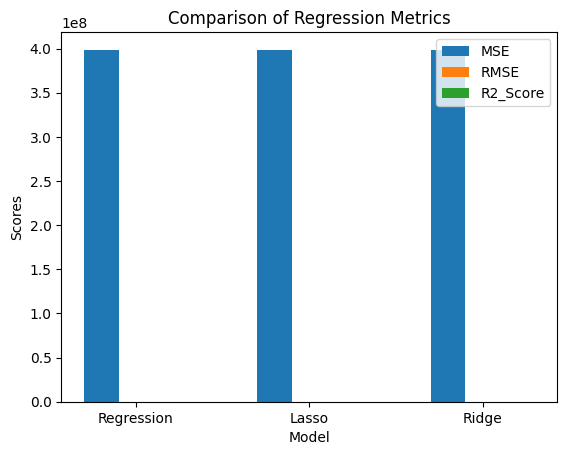

In [27]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()